In [1]:
# xclara: C = 3, |D| = 3000, F = 2
# s-set1: C = 15, |D| = 5000, F = 2
# pendigits: C = 10, |D| = 10992, F = 16
# waveform: C = 3, |D| = 5000, F = 21

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import itertools
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment as linear_assignment

#Choice of the dataset
ds = 'xclara' #'xclara','s-set1','pendigits','waveform'

df = pd.read_csv(f'dataset/{ds}.csv')
#df = pd.read_csv(f'G:/everything/università/aide/data_mining_and_machine_learning/progetto/proposal_dm_project_fcm_pedrycz/datasets/{ds}.csv')
print(ds)
print('n_cluster',len(df.iloc[:,-1].value_counts()))
print('n_feature',df.shape[1]-1)
print ('n_data', len(df.index))

N_clusters = len(df.iloc[:,-1].value_counts())
N_features = df.shape[1]-1
N_data = len(df.index)

xclara
n_cluster 3
n_feature 2
n_data 3000


# **Parameters setting**

In [90]:
#Setting of the seeds to make the experiment reproducible
random_state = centers_seed = random_clients_seed = iid_seed = shuffle_seed = 2 #123

#Setting of the learning rate
alpha = 0.001

#Setting of the max number of rounds
max_number_rounds:int = 30
    
#Setting of the distribution of data - iid=uniform, noniid=non uniform
mode = 'iid' # iid  |  non_iid_volume  |  non_iid_distr

#For final performances computation
epsilon = float(0.005)

print("fatto")

fatto


# **Some functions**

In [4]:
from abc import ABC, abstractmethod
from typing import Callable, Dict, List, Optional, Tuple
import numpy as np
import pandas as pd
from scipy.io import arff
import math
from random import randint

from sklearn.metrics import adjusted_rand_score as ARI
FROBENIUS_NORM = 'fro'

def numba_norm(u:np.ndarray, v:np.ndarray):
    return np.linalg.norm(u - v)

#This function returns the frobenius norm
def norm_fro(u:np.ndarray):
    return np.linalg.norm(u, ord = FROBENIUS_NORM)

#This function performs the frobenius norm between 2 numpy arrays u and v
# hungarian method (https://smorbieu.gitlab.io/accuracy-from-classification-to-clustering-evaluation/)
def perm_norm_fro(u:np.ndarray, v:np.ndarray):
    cm = cdist(u, v)
    indexes = linear_assignment(cm)
    indexes = np.transpose(indexes)
    js = [e[1] for e in sorted(indexes, key=lambda x: x[0])]
    v = np.asarray(v)
    original_norm = np.linalg.norm(u-v, ord = FROBENIUS_NORM)
    permuted_norm = np.linalg.norm(u-v[js], ord = FROBENIUS_NORM)
    return permuted_norm

#This function generates random centers for our clusters
def generate_random_centers(seed: int, n_clusters: int, n_features: int):
    import numpy as np
    np.random.seed(seed)
    centers = np.random.rand(n_clusters,n_features)
    return centers

print("fatto")

fatto


# **FederatedFCMeansClient**

In [79]:
class FCMeansFederatedClient:

    #Initialization of the parameters used by the client side
    def initialize(self, params: Dict) -> None:
        self.__dataset = params['dataset']
        self.__num_features = len(self.__dataset[0])
        self.__classes = [-1] * len(self.__dataset)
        self.__distance_fn = params['distance_fn']
        self.y_true = params['y_true']
        
    #Computes for each object of the dataset its nearest cluster
    def finalize(self, centers: List[np.array]) -> None:
        num_clusters = len(centers)
        dataset = self.__dataset
        num_objects = len(dataset)
        distance_fn = self.__distance_fn
        num_features = self.__num_features
 
        y_pred = []

        for i in range(num_objects):
 
            x = dataset[i]
    
            distances = []
           
            for c in range(num_clusters):
                center = centers[c]
                fro_distance = distance_fn(x, center)
                distances.append(fro_distance) 
            
            y = np.argmax(distances)
            
            y_pred.append(y) 
           
        return y_pred

    
    #Function used to calculate the value of gii and u (just the call of the method)
    def evaluate_cluster_assignment(self, centers: List) -> List[Tuple]:
        return self.__local_sums(centers)

    #finction used to calculate the value of ws and u
    def __local_sums(self, centers: List[np.array]):
        # (1) some initialization
        num_clusters = len(centers)
        dataset = self.__dataset
        num_objects = len(dataset)
        distance_fn = self.__distance_fn
        num_features = self.__num_features
        num_iterations = 5

        #Initialization
        gii = [0] * num_clusters
        u = [[0] * num_clusters for i in range(num_objects)]
        new_centers = centers
        
        for iteration in range(num_iterations):
            
            #prima di tutto aggiorno u
            for k in range(num_objects):

                u_denom = 0
                u_numer = 0
                x = dataset[k]

                for i in range(num_clusters):
                    vc = centers[i]

                    #calcolo il numeratore del denominatore di Uik
                    u_numer = (distance_fn(x, vc)) ** 2
                    
                    if u_numer == 0:
                        u_numer = np.finfo(np.float).eps
                    
                    #calcolo il denominatore del denominatore di Uik
                    for j in range(num_clusters):
                        u_denom = u_denom + (distance_fn(x, centers[j])) ** 2
                    
                     
                    if u_denom == 0:
                        u_denom = np.finfo(np.float).eps
                        
                    #
                    u[k][i] = 1/(u_numer/u_denom)
                    
            #adesso aggiorno i prototipi v
            for i in range(num_clusters):
                
                v_numer = 0
                v_denom = 0
                
                for k in range(num_objects):
                    x = dataset[k]
                    v_numer = v_numer + ((u[k][i]) ** 2) * x
                    v_denom = v_denom + ((u[k][i]) ** 2)
                    
                new_centers[i] = v_numer/v_denom
                    
            for i in range(num_clusters):
                
                gii_numer = 0
                var = 0
                mean = 0
                
                for k in range(num_objects):
                    x = dataset[k]
                    gii_numer = gii_numer + ((u[k][i]) ** 2) * (x - new_centers[i])
                    mean = mean + x
                    
                mean = mean/num_objects
                
                #calcolo la vairanza
                for k in range(num_objects):
                    var = var + (distance_fn(x, mean)) ** 2
                     
                if var == 0:
                    var = np.finfo(np.float).eps
                    
                var = var/num_objects
                
                gii[i] = -2 * gii_numer/var
                
                
        #calcolo il gradiente ed invio
        return (gii, num_objects)
        
print("fatto")

fatto


# **FederatedFCMeansServer**

In [64]:
class FCMeansFederatedServer:

    def __init__(self):
        self.__current_round = 0

    #Initialization of the parameters used by the server side
    def initialize(self, params: Dict) -> None:
        self.__alpha = params['alpha']
        self.__max_number_rounds = params.get('max_number_rounds', 10)
        self.__num_clusters = params['num_clusters']
        self.__num_features = params['num_features']
        self.__num_data = params['num_data']
        self.__norm_fm = params['norm_fn']
        self.__fnorms = []
        self.__cluster_centers = []
        self.__cluster_centers.append(params['centers'])

    #Final steps to pass to the next round    
    def next_round(self) -> bool:
        num_clusters = self.__num_clusters
        cluster_centers = self.__cluster_centers
        num_centers = len(cluster_centers)
        
        #Compute and save the frobenius norm for this round
        if (num_centers > 1):
            centers_r = np.array(cluster_centers[-1])
            centers_r_1 = np.array(cluster_centers[-2])
            tot_diff_sum = self.__norm_fm(centers_r - centers_r_1)
            self.__fnorms.append(tot_diff_sum)
        
        #Update the number of rounds
        result = self.__current_round < self.__max_number_rounds
        self.__current_round = self.__current_round + 1 if result else 0
        
        #Check if we can pass to a next round
        return result

    # lista di gii (uno per ogni client) e attuali valori dei centri, più alpha
    def process_clustering_results(self, client_responses: List):
        
        #client_responses is a list of lists in the form (gii, Nii)
        #gii is the gradient function of the client
        #Nii is the size of the data in the client
    
        num_clients = len(client_responses)
        num_clusters = self.__num_clusters
        #At each round the centers are appended to cluster_centers
        cluster_centers = self.__cluster_centers
        N = self.__num_data
        alpha = self.__alpha
        
        new_centers = []
        
        #Compute the new centers of the clusters
        for center in cluster_centers[-1]:
            
            summation = [0] * self.__num_features
            client_contribution = [0] * self.__num_features
            
            for client_idx in range(num_clients):
                client_idx_response = client_responses[client_idx]
                gii = client_idx_response[0]
                Nii = client_idx_response[1]
                betaii = Nii / N
                
                for i in gii:
                    #This is the contribution of a client
                    client_contribution = client_contribution + betaii * i
                    
                #This is the summation of the contributions of each client for a center
                summation = summation + client_contribution
                
            new_center = center - alpha * summation
            new_centers.append(np.array(new_center))
        
        #Append the new centers after the previous ones
        cluster_centers.append(new_centers)
    
        
        
    def get_centers(self) -> List:
        return self.__cluster_centers[-1]

    def current_round(self) -> int:
        return self.__current_round

    def finalize(self, enabled_print: bool = False) -> None:
        """ HERE WE CAN SAVE FOR EACH ROUND THE VALUES OF THE CENTERS """
        centers = self.__cluster_centers[1:]
        fnorms = self.__fnorms
        
        # Print the plot of the frobenius norm
        if (enabled_print):
            if N_features ==2:
                for i in range(len(centers)):
                    plt.figure()
                    plt.title(f"round {i}, Frobenius norm {fnorms[i]:.15f}")
                    plt.scatter(X[:,0],X[:,1])
                    plt.scatter(np.asarray(centers[i])[:,0],np.asarray(centers[i])[:,1],s = 30)
                    
        return (fnorms, centers)
    
print("fatto")

fatto


# **Generation of the chunks (iid/non iid)**

In [7]:
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle as shuffleSK

#Generate iid/non iid distributed chuncks of data
def generate_dataset_chunks(X: np.array, 
                            Y: np.array, 
                            n_splits: int, 
                            shuffle: bool = False, 
                            shuffle_seed:int = None, 
                            mode: str = 'iid', 
                            iid_seed: int = None):
    if (n_splits == 1):
        return [X],[Y],[]
    
    dataset_chunks = []
    y_chunks = []
    all_indices = []

    if mode == 'iid':
        
        #Provides the indices to split train/test sets 
        skf = StratifiedKFold(n_splits = n_splits, shuffle = shuffle, random_state = iid_seed)
        
        #train_index and test_index are made of 2 indices each one
        #We use the test set as a chunk (because the test sets produced by the kfold are not overlapped)
        for train_index, test_index in skf.split(X, Y):
            dataset_chunks.append(X[test_index])
            y_chunks.append(Y[test_index])
            all_indices.extend(test_index)
    
    #Not used for the project
    '''
    elif mode == 'non_iid_volume':
        
        X, Y = shuffleSK(X,Y, random_state = shuffle_seed)
        
        factor = 1.2
        total = len(X)-int(np.floor(len(X)/factor))
        print(total)
        temp = []
        
        for i in range(n_splits-1):
            val = np.random.randint(0, total)
            temp.append(val)
            total -= val
            
        temp.append(total)
        nums = [z+int(np.floor(len(X)/factor/n_splits)) for z in temp]
        cumsum = list(np.cumsum(nums))
        old = [x for x in cumsum]
        cumsum.pop(-1)
        cumsum.insert(0,0)
        
        for s,e in zip(cumsum,old):
            dataset_chunks.append(X[s:e])
            y_chunks.append(Y[s:e])
            
    elif mode == 'non_iid_distr':
        dataset_chunks = [X[i:i + int(np.floor(len(X)/n_splits)),:] for i in range(0, len(X), int(np.floor(len(X)/n_splits)))]
        y_chunks.append([Y[i:i + int(np.floor(len(X)/n_splits)),:] for i in range(0, len(X), int(np.floor(len(X)/n_splits)))])
    '''
    
    return dataset_chunks,y_chunks, all_indices

print("fatto")

fatto


# **Dataset Initialization**

In [8]:
X_original = df.iloc[:,:-1].values
Y = df.iloc[:,-1].values
df.iloc[:,-1].value_counts()

#Print the number of elements contained in each real cluster

print("fatto")

fatto


# **Plot of points with 2 not normalized features (x and y axis)**

fatto


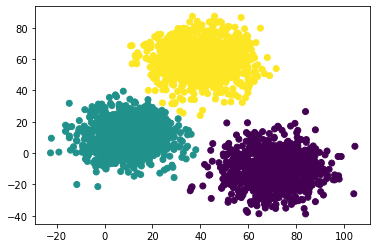

In [9]:
if N_features == 2:
    plt.scatter(X_original[:,0], X_original[:,1],c = Y)
    
print("fatto")

# **MinMax normalization of the features**

In [10]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X_original)

print("fatto")

fatto


fatto


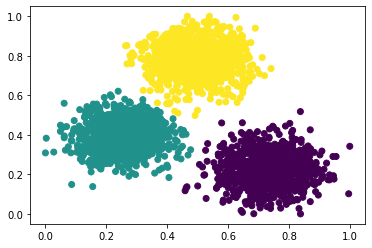

In [11]:
if N_features == 2:
    plt.scatter(X[:,0],X[:,1], c = Y)
    
print("fatto")

# **Function for executing the logic**

In [81]:
def run_experiment(N_clients: int, 
                   N_min_clients: int, 
                   centers: List[np.array], 
                   dataset_chunks: List[np.array], 
                   y_chunks: List, 
                   client_parms: Dict[str, bytes],
                   server_params: Dict[str, bytes], 
                   enabled_print: bool = False, 
                   random_clients: bool = True,
                   random_clients_seed: int = None):
    
    #Set of the seed for clients initialization
    import random
    random.seed(random_clients_seed)

    # (1) CLIENTS INITIALIZATION ==================================================================
    
    clients = []

    #We create all the clients
    for cli in range(N_clients):
        
        #We take a chunk and create the parameters of the client
        client_dataset = dataset_chunks[cli]
        params = dict(client_parms)
        client_y = y_chunks[cli]
        params['dataset'] = client_dataset
        params['y_true'] = client_y

        #We create the client object and initialize its parameters
        client = FCMeansFederatedClient()
        client.initialize(params)
        
        #We add the client to the clients
        clients.append(client)

    print(f'Starting server, total number of clients {N_clients}, min number of clients {N_min_clients}')

    active_clients_idx: List = None
        
    #If all_clients == true --> we are using all the cliants we have, if not, only a percentage
    all_clients = (N_clients == N_min_clients)

    # (2) SERVER INITIALIZATION ==================================================================
    
    #We create a server object and initialize its parameters
    server = FCMeansFederatedServer()
    server.initialize(server_params)

    # (3) FEDERATED TRAINING ====================================================================
   
    while (server.next_round()):

        #We want to pick randomly N_min_clients from the whole set
        if (random_clients and not all_clients):
            active_clients_idx = random.sample(range(N_clients), N_min_clients)
        
        centers = server.get_centers()
        
        client_responses = []
        
        # client_responses_append is a function, it is called passing the element to be appended
        client_responses_append = client_responses.append
        
        #cli = client index, client = client object
        for cli, client in enumerate(clients):
            
            #We do not consider the contribution of not selected clients
            if (not all_clients and cli not in active_clients_idx):
                continue
            response = client.evaluate_cluster_assignment(centers)
            client_responses_append(response)
        
        #When all the clients contributions are stored
        server.process_clustering_results(client_responses)
    
    #At the end of all the epochs
    centers = server.get_centers()
    
    # (4) EXECUTING SOME FINAL LOGIC ==================================================================
    
    #List of ARI VS ground through measure for each client
    ari_list = [] 
    
    y_true_list = []
    y_pred_list = []
    
    #We compute ARI VS ground through for each client
    for client in clients:
        y_pred = client.finalize(centers)
        y_true = client.y_true
        ari_list.append(ARI(y_true,y_pred))
        y_pred_list.extend(y_pred)
        y_true_list.extend(y_true)
    
    # Mean ARI VS ground through in the distributed approach
    ari_mean = np.mean(np.asarray(ari_list))
    
    #Global ARI VS ground through 
    ari_global = ARI(y_true_list,y_pred_list)

    print('\tmedia: ',ari_mean)
    print('\tglobal:',ari_global)

    return server.finalize(enabled_print), ari_mean,ari_global, y_pred_list

print("fatto")

fatto


# **Plotting functions**

In [13]:
#Plot to show how many rounds are needed to reach the convergence
def fn_fnorm_by_round_experiment_plot(all_forms_list, epsilon, dataset_file,N_min_clients_percents,rnd = True):
    fig, ax = plt.subplots(figsize = (9,4))

    marker = itertools.cycle(('d', 's', 'o', '*','<','>','+','x')) 
    labels = [f'{label:.2f}' for label in N_min_clients_percents]
    
    val = np.nanmean(all_forms_list,axis = 0)
    std = np.nanstd(all_forms_list,axis = 0)
    for i in range(len(val)):
        Y_values = val[i]
        X_labels = [i for i in range(1, len(Y_values) + 1)]
        plt.plot(X_labels, Y_values, label = labels[i], marker = next(marker),linestyle = '--')
        Y_std = std[i]
        plt.fill_between(X_labels, Y_values-Y_std, Y_values+Y_std, alpha = 0.2)

    plt.ylim([-0.01,0.1])

    #threshold line
    X_axis_threshold = [i for i in range(1, max_number_rounds + 1)]
    Y_axis_threshold = [epsilon] * max_number_rounds
    plt.text(1,epsilon+0.003,r'$\varepsilon$',size = 14)
    plt.plot(X_axis_threshold, Y_axis_threshold , 'k--', alpha=0.9)
    plt.xticks(range(1,max_number_rounds+1,2))
    plt.grid()

    # Labeling the X-axis 
    plt.xlabel('t (round)',size = 14) 
    plt.ylabel(r'$||V^{(t+1)} - V^{(t)}||_F$',size = 14) 
    legend = plt.legend(title=r"$\gamma$",fontsize = 14)
    plt.setp(legend.get_title(),fontsize=14)
    plt.tight_layout()
    plt.savefig('results/'+ds+'_round'+'_random'*rnd+'.pdf',format='pdf',bbox_inches='tight')

    plt.show()
    
    

In [87]:
#Plot to show the error wrt the percentage of partecipants (0.25, 0.50, 0.75, 1)
def fn_fnorm_by_experiment_plot(N_min_clients_percents_param, fro_list_param,rnd):
    plt.figure(figsize=(4, 4))

    X_labels = [f'{per:.2f}' for per in N_min_clients_percents_param]
    Y_values = fro_list_param.mean(axis = 0)
    Y_std = fro_list_param.std(axis = 0)
    
    plt.plot(X_labels, Y_values,'ko-')
    plt.fill_between(X_labels, Y_values-Y_std, Y_values+Y_std, color = 'k',alpha = 0.1)
    plt.grid()

    # Labeling the X-axis 
    plt.xlabel(r"Fraction of participants $\gamma$", size = 14) 
    plt.ylabel(r'$||V_{fed}(\gamma) - V_{sum}||_F$',size = 14) 
    plt.tight_layout()
    plt.savefig('results/'+ds+'_centr'+'_random'*rnd+'.pdf',format='pdf',bbox_inches='tight')
    plt.show()

# **Experiment execution function**

In [18]:
def df_complete_experiment(random_clients:bool = False, 
                           centers_seed: int = None,
                           random_clients_seed: int = None, 
                           num_splits:int = 10):
    
    centers = generate_random_centers(centers_seed, N_clusters, N_features)

    N_clients:int = 20
    shuffle_dataset:bool = True
    
    #Generate chunks
    dataset_chunks,y_chunks,all_indices = generate_dataset_chunks(X, Y, N_clients, shuffle = shuffle_dataset,
                                                                  mode = mode, shuffle_seed = shuffle_seed, iid_seed = iid_seed)
    enabled_print:bool = False

    #Set client parameters
    client_params: Dict[str, bytes] = {
        'distance_fn': numba_norm
    }

    #Set server parameters
    server_params: Dict[str, bytes] = {
        'alpha': alpha,
        'max_number_rounds': max_number_rounds,
        'num_clusters': N_clusters,
        'num_features': N_features,
        'num_data': N_data,
        'norm_fn': norm_fro,
        'centers': centers
    }

    
    ### DISTRIBUITED APPROACH, GOES FROM 0.25 to 1.0 percentage of participants from a total of N_clients available participants
    N_min_clients_percents: List[float] = [float(1/num_splits* i)  for i in range(1, num_splits + 1)]
    print(N_min_clients_percents)
    centers_list : List[List] = []
    all_forms_list: List[List] = []
    ari_clients_list: List[List] = []
    ari_clients_global: List[List] = []
    all_y_pred_fed: List[List] = []
    all_ari_fed_sum: List[List] = []
    for i in range(num_splits):
        per_clients = N_min_clients_percents[i]
        N_min_clients:int = math.floor(N_clients * per_clients)
        
        #Run the distributed algorithm and save the results
        (fnorms, centers),ari_clients_mean,ari_global,y_pred_fed = run_experiment(N_clients, N_min_clients, 
                                                                                  centers, dataset_chunks, 
                                                                                  y_chunks, client_params, 
                                                                                  server_params, enabled_print,
                                                                                  random_clients, 
                                                                                  random_clients_seed = random_clients_seed)
        ari_clients_list.append(ari_clients_mean)
        ari_clients_global.append(ari_global)
        all_forms_list.append(fnorms)
        all_y_pred_fed.append(np.asarray(y_pred_fed))
        centers_list.append(centers[-1])
    
    
    #CENTRALIZED APPROACH
    N_clients:int = 1
    shuffle_dataset:bool = True
    dataset_chunks,y_chunks,_ = generate_dataset_chunks(X, Y, N_clients, shuffle = shuffle_dataset)
    N_min_clients:int = math.floor(N_clients * per_clients)
    
    #Run the centralized algorithm and save the results
    (fnorms_centralized, centers_centralized),_,_,y_pred_sum = run_experiment(N_clients, N_min_clients, centers, 
                                                                              dataset_chunks,y_chunks, client_params, 
                                                                              server_params, enabled_print,
                                                                              random_clients, 
                                                                              random_clients_seed = random_clients_seed)
    centralized_app_center = np.array(centers_centralized[-1])
    for gamma_pred_fed in all_y_pred_fed:
        all_ari_fed_sum.append(ARI(gamma_pred_fed,np.asarray(y_pred_sum)[all_indices]))
   
    #Return all the results found both for the centralized and the distributed approaches
    return (centers_list, 
            all_forms_list, 
            centralized_app_center, 
            fnorms_centralized,
            N_min_clients_percents,
            ari_clients_list,
            ari_clients_global,
            all_ari_fed_sum)

# **Actual execution of the code**

In [82]:
num_splits = 4
random_clients = True

centers_list = []
all_forms_list = []
centralized_app_center = []
fnorms_centralized = []
N_min_clients_percents = []
ari_clients_list = []
ari_clients_global = []
all_ari_fed_sum = []


fro_list_all = []
all_forms_list_all = []
ari_clients_list_all = []
ari_clients_global_all = []
ari_pred_fed_sum_all = []

#Execution of the entire experiment 10 times with different seeds (initializations)
for rep in range(10):
    print(rep,'seed')
    
    centers_list, all_forms_list, centralized_app_center, fnorms_centralized, N_min_clients_percents, ari_clients_list,ari_clients_global,all_ari_fed_sum = df_complete_experiment(
        random_clients,
        rep, # each time different initial cluster centers 
        rep, # each time different clients selected
        num_splits)
    
    #Save the results of the execution
    
    fro_list: List[float] = []
        
    for i in range(num_splits):
        center_i = centers_list[i]
        fro_list.append(perm_norm_fro(centralized_app_center, center_i))
        
    fro_list_all.append(fro_list)
    
    for l in all_forms_list:
        l += [np.nan] * (max_number_rounds - len(l))
        
    all_forms_list_all.append(all_forms_list)
    ari_clients_list_all.append(ari_clients_list)
    ari_clients_global_all.append(ari_clients_global)
    ari_pred_fed_sum_all.append(all_ari_fed_sum)
    print()
    
#Save the entire set of results    
fro = np.asarray(fro_list_all)
all_fnorms = np.asarray(all_forms_list_all)
ari_clients = np.asarray(ari_clients_list_all)
ari_global = np.asarray(ari_clients_global_all)
ari_fed_sum = np.asarray(ari_pred_fed_sum_all)
ari_fed_sum.shape, ari_global.shape

0 seed
[0.25, 0.5, 0.75, 1.0]
Starting server, total number of clients 20, min number of clients 5
	media:  0.5154266677355478
	global: 0.5179847518294767
Starting server, total number of clients 20, min number of clients 10
	media:  0.0
	global: 0.0
Starting server, total number of clients 20, min number of clients 15
	media:  0.0
	global: 0.0
Starting server, total number of clients 20, min number of clients 20
	media:  0.0
	global: 0.0
Starting server, total number of clients 1, min number of clients 1
	media:  0.5452890812641689
	global: 0.5452890812641689

1 seed
[0.25, 0.5, 0.75, 1.0]
Starting server, total number of clients 20, min number of clients 5
	media:  0.5428935291474294
	global: 0.5450925391586355
Starting server, total number of clients 20, min number of clients 10
	media:  0.0
	global: 0.0
Starting server, total number of clients 20, min number of clients 15
	media:  0.0
	global: 0.0
Starting server, total number of clients 20, min number of clients 20
	media:  0.0
	g

((10, 4), (10, 4))

In [84]:
#Plot of the ARI table wrt the percentage of partecipants

metrics = pd.DataFrame()
metrics['ari_global_mean'] = ari_global.mean(axis = 0)
metrics['ari_global_std'] = ari_global.std(axis = 0)
metrics['ari_clients_mean'] = ari_clients.mean(axis = 0)
metrics['ari_clients_std'] = ari_clients.std(axis = 0)
metrics['fro_centers_mean'] = fro.mean(axis = 0)
metrics['fro_centers_std'] = fro.std(axis = 0)
metrics['ari_pred_fed_mean'] = ari_fed_sum.mean(axis = 0)
metrics['ari_pred_fed_std'] = ari_fed_sum.std(axis = 0)

metrics = metrics.round(5)
metrics.index = [f'{label:.2f}' for label in N_min_clients_percents]
metrics
metrics.to_csv(f'results/{ds}_metrics.csv')
pd.read_csv(f'results/{ds}_metrics.csv', index_col = 0)

,ari_global_mean,ari_global_std,ari_clients_mean,ari_clients_std,fro_centers_mean,fro_centers_std,ari_pred_fed_mean,ari_pred_fed_std
0.25,0.25851,0.25873,0.25738,0.25761,8.070665e+44,2.421200e+45,0.45527,0.45708
0.50,0.00000,0.00000,0.00000,0.00000,3.244567e+43,9.733702e+43,0.00000,0.00000
0.75,0.00000,0.00000,0.00000,0.00000,1.217644e+47,2.274174e+47,0.00000,0.00000
1.00,0.00000,0.00000,0.00000,0.00000,3.097853e+46,2.019767e+46,0.00000,0.00000


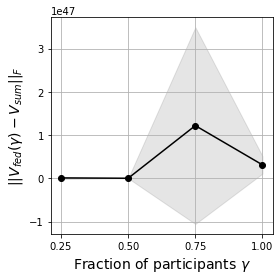

In [88]:
fn_fnorm_by_experiment_plot(N_min_clients_percents, fro, rnd = True)

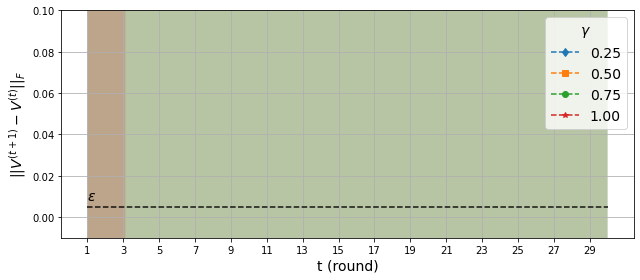

In [93]:
fn_fnorm_by_round_experiment_plot(all_fnorms, epsilon, ds, N_min_clients_percents, rnd = True)

In [92]:
centers_list

[[array([0.48185702, 0.48843046]),
  array([0.48185699, 0.48843056]),
  array([0.48185717, 0.48843006])],
 [array([-45104.09036844, -34548.25170209]),
  array([-45103.73209122, -34548.39633374]),
  array([-45103.92300936, -34547.9229271 ])],
 [array([ 2.10825495e+45, -1.87137211e+07]),
  array([ 2.10825495e+45, -1.87137211e+07]),
  array([ 2.10825495e+45, -1.87137216e+07])],
 [array([9.00542494e+45, 6.29188357e+45]),
  array([9.00542494e+45, 6.29188357e+45]),
  array([9.00542494e+45, 6.29188357e+45])]]